In [1]:
import pandas as pd
import keras
import os
from data_loading import load_tracking_data
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import spatial
import numpy as np
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from utility_db_25 import mark_columns, TrainML
from utility_db_25 import mark_columns, TrainML, get_momentum_cols, create_momentum_index, get_motion_cols, motion_complexity_score
root_dir = os.getcwd()

# Load data

We first load our data, starting with tracking & general player data

In [2]:
# load tracking data for all weeks
root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
df_tracking = pd.concat(
        [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
    )

# get players data
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))

# load tracking, truncate to relevant columns, delete
cols_track = ['gameId','playId','nflId','frameId','club','x_standard','y_standard', 'dis', 'dir_standard']
track_trunc = df_tracking[cols_track]
del(df_tracking)

In [3]:
#track_trunc=pd.read_csv('data/tracking_trunc.csv')
df_games = pd.read_csv('data/games.csv')[[
    'gameId','week'
]].drop_duplicates()
track_trunc=pd.merge(track_trunc, df_games, on='gameId', how='inner')

### Merge onto play level

Note: some plays (38?) lack defensive tracking data, ergo losing some plays to dropping NA's 


In [4]:
# merge  tracking info to play-level data
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
play_trunc = df_plays[['gameId','playId','possessionTeam','isDropback']]
pt_df = pd.merge(track_trunc,play_trunc, how='left',right_on=['gameId','playId','possessionTeam'],
                 left_on=['gameId','playId','club'])

# na's dropped to lose players w/o tracking info
def_df = pt_df.dropna().copy()
def_df.head(3)

,gameId,playId,nflId,frameId,club,x_standard,y_standard,dis,dir_standard,week,possessionTeam,isDropback
112,2022091200,64,39987.0,2,SEA,33.95,23.50,0.04,19.89,1,SEA,False
113,2022091200,64,39987.0,3,SEA,33.96,23.54,0.04,19.91,1,SEA,False
114,2022091200,64,39987.0,4,SEA,33.98,23.58,0.05,24.17,1,SEA,False


In [5]:
# get position here for calcs
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))
def_temp = def_df.merge(df_players[['nflId','position']],how='left',copy=False)
def_temp.sort_values(by=['gameId','playId','frameId'],inplace=True)
del(track_trunc)
del(df_players)
def_temp.head()
def_temp.drop(columns='week', inplace=True)

In [6]:

ci = pd.merge(def_temp[['gameId','playId']].drop_duplicates(), pd.Series(list(range(1,201))).rename('frameId'), how='cross',copy=False).sort_values(by=['gameId','playId','frameId'])
ci=pd.merge(df_games, ci, on=['gameId'])[['gameId', 'playId', 'frameId', 'week']]
ci_merged = pd.merge(ci, def_temp,on=['gameId', 'playId', 'frameId'],how='left',copy=False)[['gameId', 'playId', 'frameId', 'week']].drop_duplicates()

In [7]:
len(ci)

3217200

In [8]:
len(def_temp)

18371122

In [9]:
len(ci_merged)

3217200

In [10]:
off_positions=['WR','T','G', 'TE',  'RB', 'QB']
for p in off_positions:
    df=def_temp[def_temp['position']==p][['gameId', 'playId', 'frameId','dir_standard', 'dis', 'x_standard', 'y_standard']].groupby(['gameId', 'playId', 'frameId']).agg({'dir_standard': 'mean', 'dis':'sum', 'x_standard':'mean', 'y_standard':'mean'}).reset_index().copy()
    df.columns = ['gameId', 'playId', 'frameId',p+'_dir', p+'_dis', p+'x_standard', p+'y_standard']
    ci_merged=ci_merged.merge(df,how='left',on=['gameId','playId','frameId'])
    del(df)
ci_merged.fillna(0, inplace=True)

In [11]:
# merge back in
db_df = def_df[['gameId','playId','isDropback']].drop_duplicates()
ci_pre = ci_merged.merge(db_df,how='left')
del(ci_merged)
del(def_df)
ci_pre=ci_pre[ci_pre['week']>0]

In [12]:
ci_pre.week.max()

9

In [13]:
len(ci_pre)/200

16086.0

### Perform train/test split

We integrate week data, then subset based on week 9 holdout:

In [14]:
# subset week
df_train = ci_pre[(ci_pre['week'] <9.0) ].drop_duplicates()
df_test = ci_pre[ci_pre['week'] ==9.0].drop_duplicates()

# y = isDropback
y_train = df_train['isDropback'].astype(int)
y_test = df_test['isDropback'].astype(int)

In [15]:
len(df_train)/200

14556.0

In [16]:
len(df_train[['gameId','playId']].drop_duplicates())

14556

In [17]:
df_train.fillna(0, inplace=True)

In [18]:
len(df_train.drop(columns=['gameId', 'playId', 'frameId', 'week', 'isDropback']).columns)

24

### Scale data, then reshape for RNN:

In [19]:
# define scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scale

In [20]:
# load original data
train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
train_motion_cols=get_motion_cols(train_data.columns)
train_momentum_cols=get_momentum_cols(train_data.columns)

test_motion_cols=get_motion_cols(test_data.columns)
test_momentum_cols=get_momentum_cols(test_data.columns)


train_data=create_momentum_index(train_data, train_momentum_cols)
test_data=create_momentum_index(test_data, test_momentum_cols)

train_data=motion_complexity_score(train_data, test_motion_cols)
test_data=motion_complexity_score(test_data, test_motion_cols)
final_features=['gameId', 'playId', 'xpass_situational',
 'neg_alignment',
 'neg_Formations',
 'off_xpass',
 'QBdffy_RB',
 'motion-momentum',
 'receiverAlignment_3x2',
 'QBdff_WR']
df_train=pd.merge(df_train, train_data[final_features], on=['gameId', 'playId'], how='inner')
df_test=pd.merge(df_test, test_data[final_features], on=['gameId', 'playId'], how='inner')

In [21]:
df_test.sort_values(by='QBy_standard',ascending=False)

,gameId,playId,frameId,week,WR_dir,WR_dis,WRx_standard,WRy_standard,T_dir,T_dis,...,QBy_standard,isDropback,xpass_situational,neg_alignment,neg_Formations,off_xpass,QBdffy_RB,motion-momentum,receiverAlignment_3x2,QBdff_WR
210301,2022110608,193,102,9,1.68,0.00,73.43,14.153333,223.410,0.00,...,40.203333,False,0.449673,0,0,0.553442,10.810545,0.0,1,74.617683
210248,2022110608,193,49,9,140.33,0.01,73.41,14.103333,129.635,0.02,...,40.193333,False,0.449673,0,0,0.553442,10.810545,0.0,1,74.617683
210270,2022110608,193,71,9,61.20,0.01,73.45,14.143333,191.430,0.00,...,40.193333,False,0.449673,0,0,0.553442,10.810545,0.0,1,74.617683
210278,2022110608,193,79,9,46.94,0.00,73.43,14.133333,151.035,0.00,...,40.193333,False,0.449673,0,0,0.553442,10.810545,0.0,1,74.617683
210247,2022110608,193,48,9,144.19,0.01,73.41,14.093333,124.650,0.02,...,40.193333,False,0.449673,0,0,0.553442,10.810545,0.0,1,74.617683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136918,2022110604,3201,119,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,0.000000,True,0.765692,0,0,0.648868,15.898611,1.0,0,69.897481
136919,2022110604,3201,120,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,0.000000,True,0.765692,0,0,0.648868,15.898611,1.0,0,69.897481
136920,2022110604,3201,121,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,0.000000,True,0.765692,0,0,0.648868,15.898611,1.0,0,69.897481
136921,2022110604,3201,122,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,0.000000,True,0.765692,0,0,0.648868,15.898611,1.0,0,69.897481


In [22]:
df_train.columns.values

array(['gameId', 'playId', 'frameId', 'week', 'WR_dir', 'WR_dis',
       'WRx_standard', 'WRy_standard', 'T_dir', 'T_dis', 'Tx_standard',
       'Ty_standard', 'G_dir', 'G_dis', 'Gx_standard', 'Gy_standard',
       'TE_dir', 'TE_dis', 'TEx_standard', 'TEy_standard', 'RB_dir',
       'RB_dis', 'RBx_standard', 'RBy_standard', 'QB_dir', 'QB_dis',
       'QBx_standard', 'QBy_standard', 'isDropback', 'xpass_situational',
       'neg_alignment', 'neg_Formations', 'off_xpass', 'QBdffy_RB',
       'motion-momentum', 'receiverAlignment_3x2', 'QBdff_WR'],
      dtype=object)

In [23]:
final_features=[ 'WR_dir', 'WR_dis',
       'WRx_standard', 'WRy_standard', 'T_dir', 'T_dis', 'Tx_standard',
       'Ty_standard', 'G_dir', 'G_dis', 'Gx_standard', 'Gy_standard',
       'TE_dir', 'TE_dis', 'TEx_standard', 'TEy_standard', 'RB_dir',
       'RB_dis', 'RBx_standard', 'RBy_standard', 'QB_dir', 'QB_dis',
       'QBx_standard', 'QBy_standard',  'xpass_situational',
       'neg_alignment', 'neg_Formations', 'off_xpass', 'QBdffy_RB',
       'motion-momentum', 'receiverAlignment_3x2', 'QBdff_WR']

In [24]:
X_train=df_train[final_features]
X_test=df_test[final_features]


In [25]:
X_test.isna().sum()

WR_dir                   0
WR_dis                   0
WRx_standard             0
WRy_standard             0
T_dir                    0
T_dis                    0
Tx_standard              0
Ty_standard              0
G_dir                    0
G_dis                    0
Gx_standard              0
Gy_standard              0
TE_dir                   0
TE_dis                   0
TEx_standard             0
TEy_standard             0
RB_dir                   0
RB_dis                   0
RBx_standard             0
RBy_standard             0
QB_dir                   0
QB_dis                   0
QBx_standard             0
QBy_standard             0
xpass_situational        0
neg_alignment            0
neg_Formations           0
off_xpass                0
QBdffy_RB                0
motion-momentum          0
receiverAlignment_3x2    0
QBdff_WR                 0
dtype: int64

### Define features, match indices

We make sure our indices align, and that we have no feature overlap with our previous static-fed model:

### Build LGBM

We train the model:

Training Folds: 100%|██████████| 5/5 [00:54<00:00, 10.87s/it]

Mean Train AUC --> 0.8053
Mean Validation AUC ---> 0.8050
Mean Train Accuracy --> 0.8155
Mean Validation Accuracy ---> 0.8153


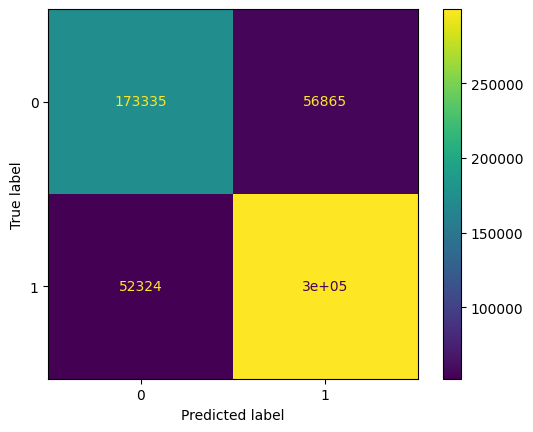

In [26]:
#lgbm classifier
scaler = MinMaxScaler(feature_range=(0, 1))
pipeline=Pipeline([('tr', scaler), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X_train,y_train)
TrainML(pipeline,X_train, y_train,5,SEED=42)

In [27]:
pipeline.fit(X_train, y_train)
y_preds=pipeline.predict(X_test)
y_prob=pipeline.predict_proba(X_test)[:,1]

[Pipeline] ................ (step 1 of 2) Processing tr, total=   3.0s
[Pipeline] .............. (step 2 of 2) Processing lgbm, total=   5.7s


In [28]:
y_prob

array([0.44964598, 0.41888098, 0.42211323, ..., 0.34151522, 0.34151522,
       0.34151522])

In [29]:

reshaped_data = y_preds.reshape((int(len(y_preds)/200), 200, ))


In [30]:
len(y_preds)

306000

In [31]:
predictions=[]
for i in reshaped_data:
    predictions.append(i.max())
predictions

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,


In [32]:
y_true=test_data['pass']

In [33]:
accuracy_score(y_true, predictions)

0.8124183006535948

In [34]:
#df_test[df_test['xpass_situational']<.2]

In [35]:
df_test['predictions'] = y_prob

In [36]:
df_test.sample(20)

,gameId,playId,frameId,week,WR_dir,WR_dis,WRx_standard,WRy_standard,T_dir,T_dis,...,isDropback,xpass_situational,neg_alignment,neg_Formations,off_xpass,QBdffy_RB,motion-momentum,receiverAlignment_3x2,QBdff_WR,predictions
181511,2022110606,2965,112,9,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,True,0.508368,1,0,0.647155,16.004222,0.0,0,99.065778,0.412227
171946,2022110606,1315,147,9,192.403333,0.05,64.463333,29.643333,354.690000,0.00,...,True,0.487790,0,0,0.675327,12.848147,2.0,0,88.628425,0.829707
166183,2022110606,354,184,9,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,False,0.481210,1,0,0.658605,2.548116,-1.0,0,132.610178,0.343736
128743,2022110604,1862,144,9,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,True,0.977210,0,0,0.606415,15.907210,0.0,0,82.785717,0.964746
58848,2022110601,1791,49,9,116.333333,0.37,84.916667,18.716667,161.955000,0.03,...,True,0.924754,0,0,0.664371,16.047477,1.0,0,113.411738,0.946774
14262,2022110300,2211,63,9,277.923333,0.07,91.710000,25.080000,124.585000,0.02,...,True,0.416764,0,0,0.549018,15.904174,0.0,0,100.053851,0.471509
231550,2022110608,4303,151,9,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,False,0.500000,0,0,0.508533,1.225000,0.0,0,162.913510,0.078061
224231,2022110608,2793,32,9,177.000000,0.01,92.775000,40.810000,157.370000,0.00,...,False,0.240968,0,0,0.597837,16.466224,0.0,0,111.283959,0.256235
65812,2022110601,2953,13,9,23.700000,0.31,99.470000,27.020000,97.753333,0.74,...,True,0.438299,1,1,0.438050,11.955618,0.0,0,79.770876,0.124427
118383,2022110604,194,184,9,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,True,0.891419,0,0,0.606229,16.271627,1.0,0,79.138905,0.763149


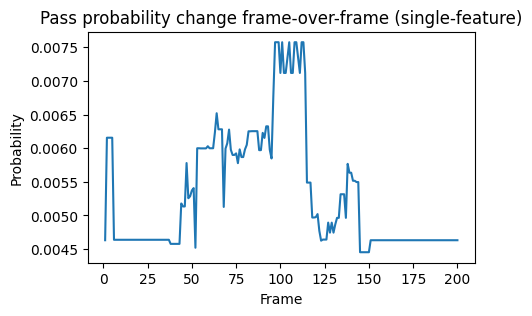

In [37]:
example=df_test[(df_test['gameId']==2022110300)& (df_test['playId']==3407)][['frameId', 'predictions']]
plt.figure(figsize=(5,3))
plt.title('Pass probability change frame-over-frame (single-feature)')
plt.xlabel('Frame')
plt.ylabel('Probability')
plt.plot(example['frameId'],example['predictions'])
plt.show()